In [0]:
import keras as keras
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Flatten, InputLayer
from keras.layers import Conv2D, MaxPooling2D
from keras.utils import to_categorical
from keras.preprocessing import image
from keras.applications.vgg16 import VGG16

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import keras.backend as K
import os
from tqdm import tqdm
%matplotlib inline

In [3]:
train = pd.read_csv('Multi_Label_dataset/train.csv')

train_image = []
for i in tqdm(range(train.shape[0])):
    img = image.load_img('Multi_Label_dataset/Images/'+train['Id'][i]+'.jpg',target_size=(224,224,3))
    img = image.img_to_array(img)
    img = img/255
    train_image.append(img)
X = np.array(train_image)

y = np.array(train.drop(['Id', 'Genre'],axis=1))

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.2)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, random_state=42, test_size=0.2)

100%|██████████| 7254/7254 [00:19<00:00, 367.22it/s]


## Viewing the class distributions. As seen most of the dataset is extremely imabalanced, in some cases such as Reality-TV/Western/News are hardly visble. Considering that the problem has Multiple Labels it shouldnt be possible to divide the dataset with stratification further contributing to the problem of the class distribution.

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  This is separate from the ipykernel package so we can avoid doing imports until


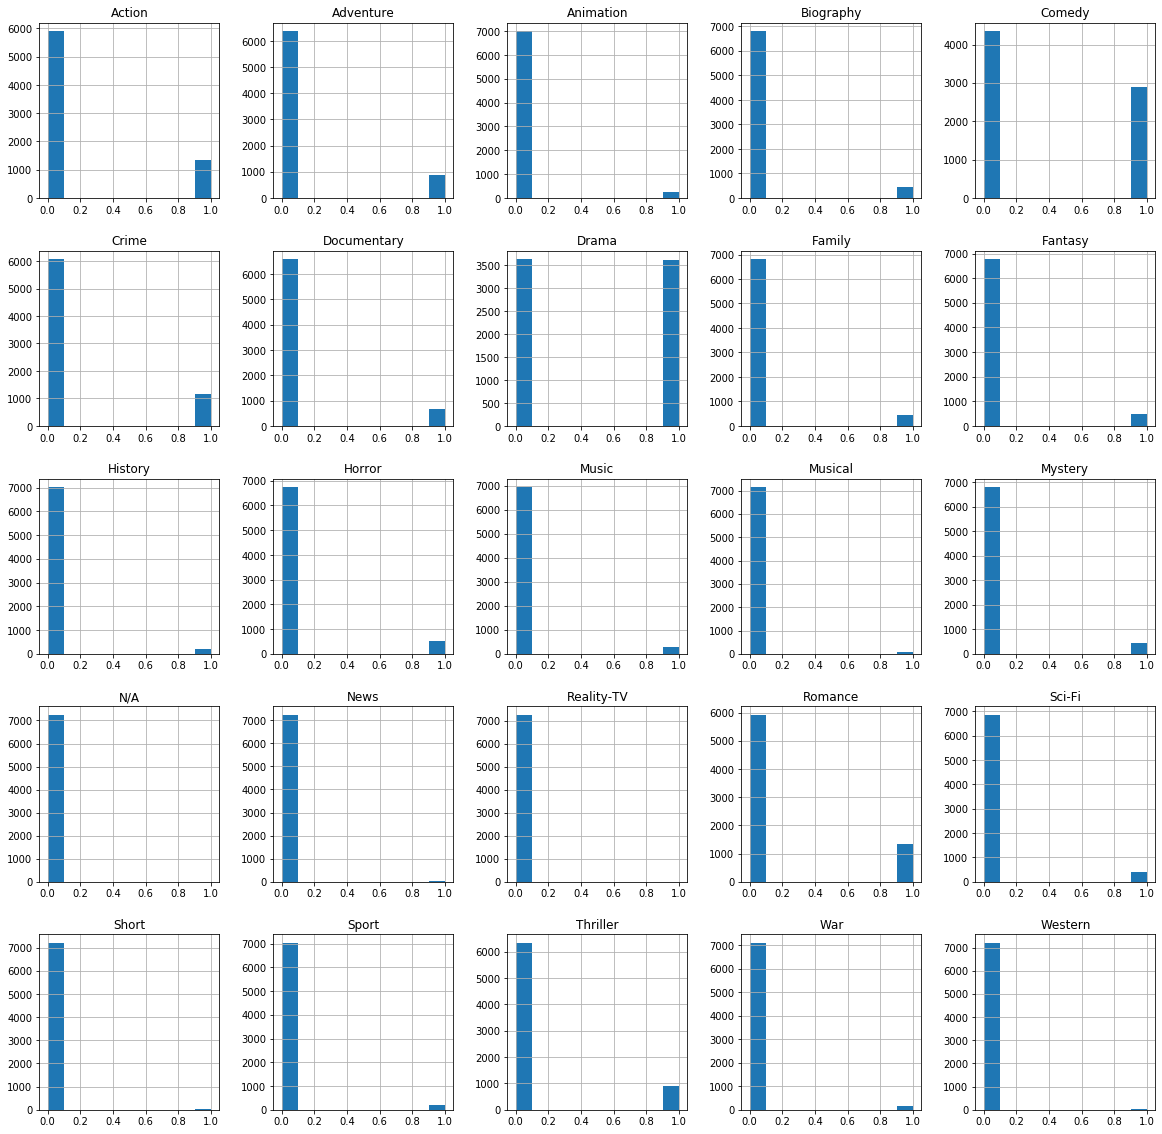

In [4]:
fig = plt.figure(figsize = (20,20))
ax = fig.gca()
train.drop(['Id', 'Genre'],axis=1).hist(ax = ax)
plt.show()

# Making and compiling the CNN model

In [5]:
model = Sequential()
model.add(Conv2D(filters=16, kernel_size=(5, 5), activation="relu", input_shape=(224,224,3)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Conv2D(filters=32, kernel_size=(5, 5), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Conv2D(filters=64, kernel_size=(5, 5), activation="relu"))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Conv2D(filters=64, kernel_size=(5, 5), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(25, activation='sigmoid'))

model.summary()






Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 220, 220, 16)      1216      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 110, 110, 16)      0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 110, 110, 16)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 106, 106, 32)      12832     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 53, 53, 32)        0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 53, 53, 32)        0         


## Training with a weighted loss function for 20 epochs

# For the sake of experimentation we soldier on despite the heavily unfair class distributions and the lack of stratification. Instead utilizing a simplistic approach of utilizing a 2-d weighted loss function to account of the class imbalance.

# The model will be trained for 20 epochs with same model as before and tested to see how much its perfomance shifts (spoiler alert : Not much)

In [6]:
import os

import tensorflow as tf
import keras.backend as K
from sklearn.metrics import hamming_loss
from sklearn.utils.class_weight import compute_class_weight

def calculating_class_weights(y_true):
    number_dim = np.shape(y_true)[1]
    weights = np.empty([number_dim, 2])
    for i in range(number_dim):
        weights[i] = compute_class_weight('balanced', [0.,1.], y_true[:, i])
    return weights

def get_weighted_loss(weights):
    def weighted_loss(y_true, y_pred):
        return K.mean((weights[:,0]**(1-y_true))*(weights[:,1]**(y_true))*K.binary_crossentropy(y_true, y_pred), axis=-1)
    return weighted_loss

class_weights = calculating_class_weights(y_train)
model.compile(optimizer='adam', loss=get_weighted_loss(class_weights), metrics=['accuracy'])

model.fit(X_train, y_train, epochs=20, validation_data=(X_val, y_val), batch_size=32)



Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



Train on 4642 samples, validate on 1161 samples
Epoch 1/20





4642/4642 [==============================] - 19s 4ms/step - loss: 0.6968 - acc: 0.0603 - val_loss: 0.6810 - val_acc: 0.0017
Epoch 2/20
4642/4642 [==============================] - 5s 1ms/step - loss: 0.6936 - acc: 0.0433 - val_loss: 0.6813 - val_acc: 0.0095
Epoch 3/20
4642/4642 [==============================] - 5s 1ms/step - loss: 0.6944 - acc: 0.0418 - val_loss: 0.6806 - val_acc: 8.6133e-04
Epoch 4/20
4642/4642 [==============================] - 5s 1ms/step - loss: 0.6944 - acc: 0.0347 - val_loss: 0.6805 - val_acc: 0.0000e+00
Epoch 5/20
4642/4642 [==============================] - 5s 1ms/step - loss: 0.6946 - acc: 0.0293 - val_loss: 0.6808 - val_acc: 0.0396
Epoch 6/20
4642/4642 [==============================] - 5s 1ms/step - loss: 0.6943 - acc: 0.0198 - val_loss: 0.6805 - val_acc: 0.0396
Epoch 7/20
4642/4642 [=============

# Assesing Model performance
## As seen the presence of the weighted loss function has made significant changes to the 


label_ranking_average_precision_score
0.7092692236239926

hamming_loss
0.6103014642549526

Classwise f1_score


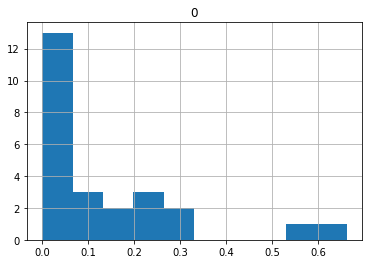

In [20]:
from sklearn.metrics import f1_score, label_ranking_average_precision_score, hamming_loss

pred = model.predict(X_val)

print("\nlabel_ranking_average_precision_score")
print(label_ranking_average_precision_score(np.round(pred), y_val))

print("\nhamming_loss")
print(hamming_loss(np.round(pred), y_val))

print("\nClasswise f1_score")
f1 = []
for i in list(pd.DataFrame(np.round(y_val))):
  f1.append([f1_score(pd.DataFrame(np.round(pred))[i], pd.DataFrame(np.round(y_val))[i])])

pd.DataFrame(f1).hist()
plt.show()